#PROFANITY FILTERING IN AUDIO




The project aims to develop an automated system for censoring profane language in audio recordings. The system utilizes speech-to-text transcription to identify profane words within the audio. Upon detection of profanity, the system removes the corresponding audio segments from the recording and inserts one second of silence before and after each profane word interval. Additionally, a short beep sound is inserted within the profane word intervals to alert listeners of the censored content. The implementation involves using machine learning models for speech recognition and profanity detection, as well as signal processing techniques to manipulate the audio data. The system provides an efficient and automated approach to censor profanity in audio recordings, suitable for various applications such as content moderation in media platforms, educational resources, and communication systems.

# INSTALING DEPENDENCY


Inspired from package profanity of Ben Friedland, this library is significantly faster than the original one, by using string comparison instead of regex.

In [ ]:
!pip install better-profanity

Whisper is an automatic speech recognition (ASR) system trained on 680,000 hours of multilingual and multitask supervised data collected from the web. We show that the use of such a large and diverse dataset leads to improved robustness to accents, background noise and technical language. Moreover, it enables transcription in multiple languages, as well as translation from those languages into English. We are open-sourcing models and inference code to serve as a foundation for building useful applications and for further research on robust speech processing.

In [ ]:
!pip install openai-whisper

PyDub 's AudioSegment class makes it easy to import and manipulate audio files with Python.

In [ ]:
!pip install pydub

## Used to visualize the words

In [ ]:
!pip install wordcloud


# IMPORTING LIBRARYS

In [ ]:
import pandas as pd
import numpy as np
import wave
from pydub import AudioSegment
import better_profanity
from math import ceil
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy import displacy
import networkx as nx
from pydub.effects import normalize
import os
import numpy as np
import pandas as pd
import wave
import better_profanity

# PROFANITY WORD ANALYSIS

In [ ]:
import pandas as pd

with open('/content/drive/MyDrive/profanity_wordlist.txt', 'r') as file:
    words = file.read().split()


alphabet_dict = {chr(i): [] for i in range(ord('A'), ord('Z')+1)}

# Classify words by alphabet
for word in words:
    first_letter = word[0].upper()
    if first_letter in alphabet_dict:
        alphabet_dict[first_letter].append(word)


max_length = max(len(words) for words in alphabet_dict.values())

for key, value in alphabet_dict.items():
    alphabet_dict[key] += [''] * (max_length - len(value))

# Create DataFrame
df = pd.DataFrame(alphabet_dict)

# Display the DataFrame
print(df)

In [ ]:
df.to_csv('word.csv', index=False)

In [ ]:
category_counts = df.applymap(lambda x: 0 if x == '' else 1).sum()

# Display the counts
print(category_counts)

A     20
B     35
C     41
D     32
E     17
F    112
G     36
H     43
I      3
J     15
K     30
L     24
M     61
N     34
O     16
P     83
Q      7
R     25
S    104
T     46
U      7
V     12
W     35
X      3
Y      2
Z      0
dtype: int64


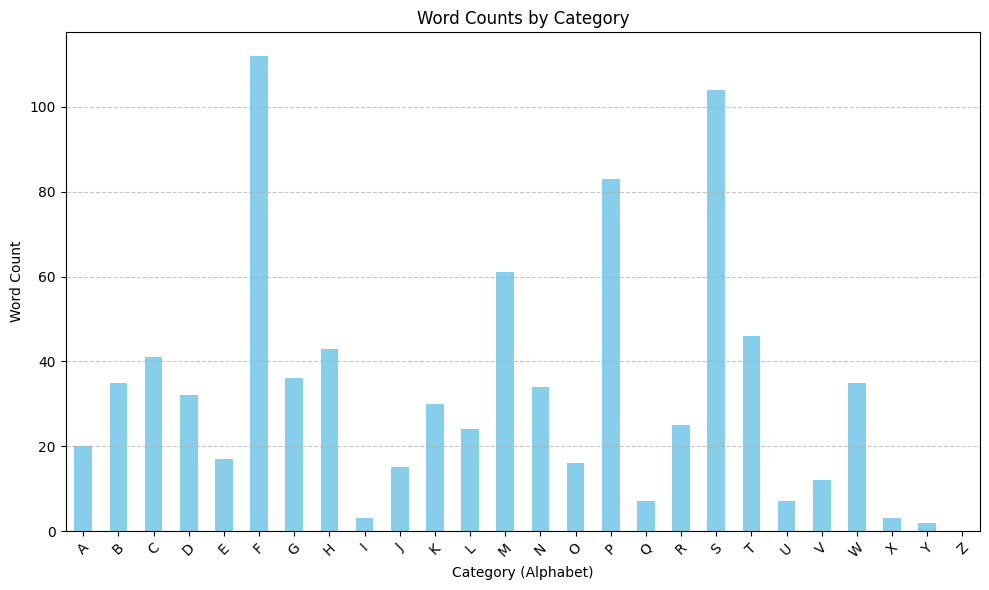

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Word Counts by Category')
plt.xlabel('Category (Alphabet)')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


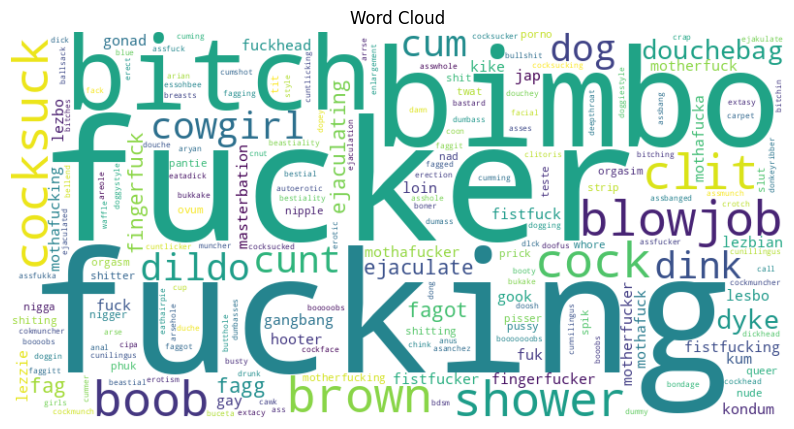

In [ ]:
# Join all words into a single string
all_words = ' '.join(words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()


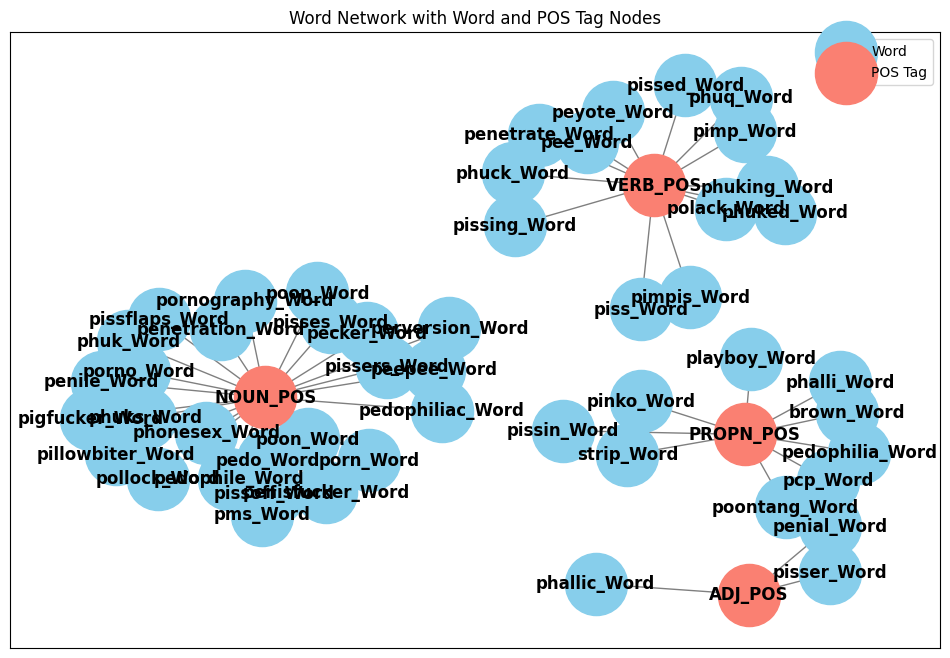

In [ ]:
# Load the English language model in spaCy
nlp = spacy.load("en_core_web_sm")

# Sample DataFrame
df = pd.DataFrame(alphabet_dict)

# Combine all words from the DataFrame into a single list
all_words = [word for column in df.columns for word in df[column] if word != '']

# Count the frequency of each word
word_counts = pd.Series(all_words).value_counts()

# Select the top 50 most frequent words
top_50_words = word_counts.head(50).index.tolist()

# Initialize a networkx graph
G = nx.Graph()

# Iterate over the top 50 words
for word in top_50_words:
    # Process the word with spaCy
    doc = nlp(word)
    # Iterate over tokens in the processed word
    for token in doc:
        # Combine word and its POS tag as node label
        word_node = f"{token.text}_Word"
        pos_node = f"{token.pos_}_POS"
        # Add nodes to the graph
        G.add_node(word_node)
        G.add_node(pos_node)
        # Connect word node to its corresponding POS tag node
        G.add_edge(word_node, pos_node)

# Plot the network
plt.figure(figsize=(12, 8))

# Generate layout
pos = nx.spring_layout(G, k=0.4)

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if "_Word" in node],
                       node_color='skyblue', node_size=2000, label='Word')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if "_POS" in node],
                       node_color='salmon', node_size=2000, label='POS Tag')

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Display the legend
plt.legend()

# Set title
plt.title('Word Network with Word and POS Tag Nodes')

# Show the plot
plt.show()





# AUDIO ANALYSIS & PREPROCESSING


In [ ]:
def analyze_wav_file(file_path):
    try:
        # Open the WAV file
        with wave.open(file_path, 'rb') as wav_file:
            # Get basic information about the WAV file
            num_channels = wav_file.getnchannels()
            sample_width = wav_file.getsampwidth()
            frame_rate = wav_file.getframerate()
            num_frames = wav_file.getnframes()
            duration = num_frames / frame_rate

            print("WAV file information:")
            print(f"Number of channels: {num_channels}")
            print(f"Sample width (bytes): {sample_width}")
            print(f"Frame rate (frames per second): {frame_rate}")
            print(f"Number of frames: {num_frames}")
            print(f"Duration (seconds): {duration:.2f}")


            frames = wav_file.readframes(num_frames)


    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except wave.Error as e:
        print(f"Error reading WAV file: {e}")


file_path = "//content/drive/MyDrive/grinder-drum-loop-6697.wav"
analyze_wav_file(file_path)



WAV file information:
Number of channels: 2
Sample width (bytes): 2
Frame rate (frames per second): 24000
Number of frames: 710208
Duration (seconds): 29.59


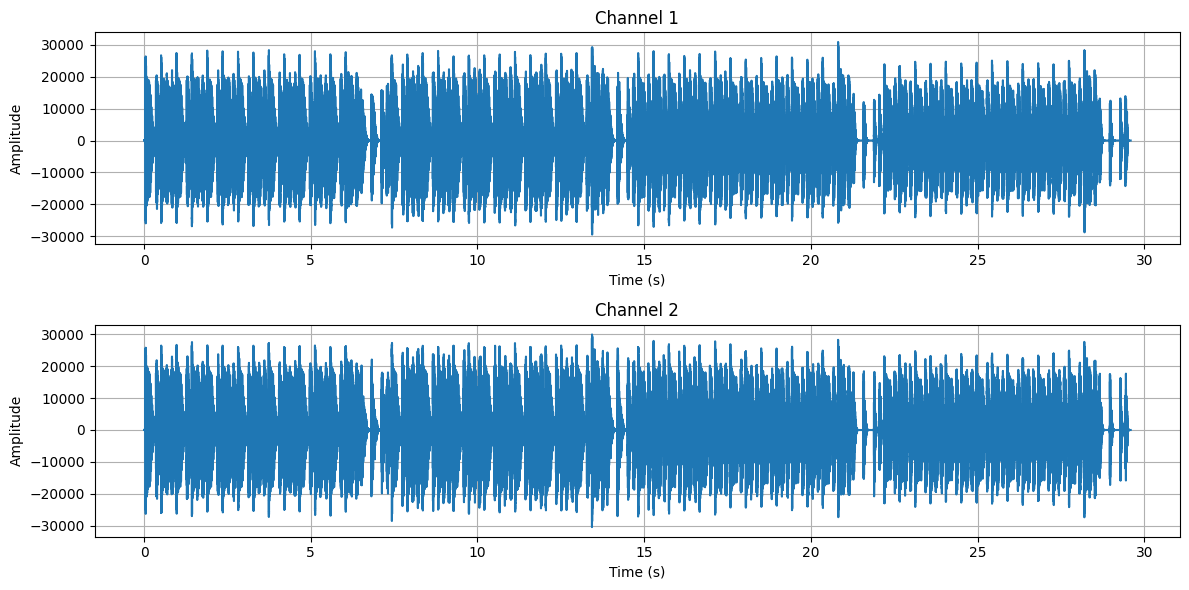

In [ ]:
# Load the WAV file
file_path = '/content/drive/MyDrive/grinder-drum-loop-6697.wav'
with wave.open(file_path, 'rb') as wav_file:
    num_channels = wav_file.getnchannels()
    frame_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    sample_width = wav_file.getsampwidth()

    # Read all frames from the WAV file
    frames = wav_file.readframes(num_frames)

# Convert frames to a NumPy array
samples = np.frombuffer(frames, dtype=np.int16)

# Reshape the samples into a 2D array for stereo
samples = samples.reshape(-1, num_channels)

# Calculate time array
time = np.arange(0, num_frames) / frame_rate

# Plot each channel separately in parallel
plt.figure(figsize=(12, 6))
for i in range(num_channels):
    plt.subplot(2, 1, i + 1)
    plt.plot(time, samples[:, i])
    plt.title(f'Channel {i + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()



## CONVERT STEREO INTO MONO

In [ ]:
def stereo_to_mono(input_path, output_path):
    # Open the stereo WAV file
    with wave.open(input_path, 'rb') as wav_in:
        # Get parameters of the stereo WAV file
        num_channels = wav_in.getnchannels()
        num_frames = wav_in.getnframes()
        sample_width = wav_in.getsampwidth()
        frame_rate = wav_in.getframerate()

        # Check if the input file is stereo
        if num_channels != 2:
            print("Input file is not stereo.")
            return

        # Open a new mono WAV file for writing
        with wave.open(output_path, 'wb') as wav_out:
            # Set parameters for the mono file
            wav_out.setnchannels(1)  # Mono
            wav_out.setsampwidth(sample_width)
            wav_out.setframerate(frame_rate)
            wav_out.setnframes(num_frames)

            # Read and process frames
            for _ in range(num_frames):
                # Read one frame from the stereo file
                frame_stereo = wav_in.readframes(1)
                # Extract left and right channel values
                left_channel = int.from_bytes(frame_stereo[:2], byteorder='little', signed=True)
                right_channel = int.from_bytes(frame_stereo[2:], byteorder='little', signed=True)
                # Combine left and right channels into mono by averaging
                mono_value = (left_channel + right_channel) // 2
                # Ensure the mono value is within the valid range for a 16-bit signed integer
                mono_value = max(-32768, min(mono_value, 32767))
                # Pack the mono value into a binary string
                frame_mono = wave.struct.pack("<h", mono_value)
                # Write the mono frame to the new file
                wav_out.writeframes(frame_mono)

input_file = '/content/drive/MyDrive/grinder-drum-loop-6697.wav'
output_file = 'mono_file.wav'
stereo_to_mono(input_file, output_file)


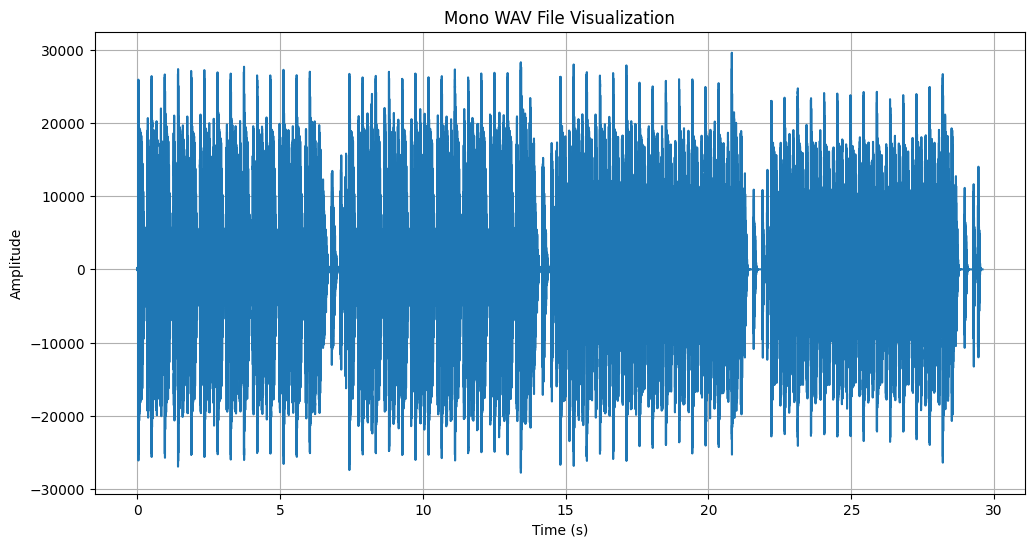

In [ ]:
def plot_wav(file_path):
    # Open the WAV file
    with wave.open(file_path, 'rb') as wav_file:
        # Get the parameters of the WAV file
        num_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        frame_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()

        # Read all frames from the WAV file
        frames = wav_file.readframes(num_frames)

    # Convert frames to a NumPy array
    samples = np.frombuffer(frames, dtype=np.int16)

    # Calculate time array
    duration = num_frames / frame_rate
    time = np.linspace(0, duration, num=num_frames)

    # If stereo, plot each channel separately
    if num_channels == 2:
        plt.figure(figsize=(12, 6))
        plt.plot(time, samples[:, 0], label='Left Channel')
        plt.plot(time, samples[:, 1], label='Right Channel')
        plt.title('Stereo WAV File Visualization')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
    else:
        # If mono, plot single channel
        plt.figure(figsize=(12, 6))
        plt.plot(time, samples)
        plt.title('Mono WAV File Visualization')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)

    plt.show()

wav_file_path = '/content/mono_file.wav'
plot_wav(wav_file_path)


In [ ]:
from pydub import AudioSegment
from pydub.effects import normalize, low_pass_filter
from pydub.silence import split_on_silence
import os

def preprocess_audio(audio):
    # Normalize the audio to -20 dB
    audio = normalize(audio, headroom=0.1)

    # Apply a low-pass filter to remove high-frequency noise
    audio = low_pass_filter(audio, cutoff_hz=4000)

    return audio

def clean_audio(input_file, output_file):
    # Load the audio file
    audio = AudioSegment.from_file(input_file)

    # Preprocess the audio
    audio = preprocess_audio(audio)

    # Split audio on silence
    audio_chunks = split_on_silence(audio, min_silence_len=500, silence_thresh=-40)

    # Combine chunks with at least 500ms of silence between them
    cleaned_audio = AudioSegment.silent(duration=0)
    for chunk in audio_chunks:
        cleaned_audio += chunk

    # Export the cleaned audio in WAV format
    cleaned_audio.export(output_file, format="wav")

def main():
    # Input file path
    input_file = "/content/drive/MyDrive/grinder-drum-loop-6697.mp3"

    # Output file path
    output_file = os.path.splitext(input_file)[0] + "_cleaned.wav"

    # Check if the input file exists
    if not os.path.exists(input_file):
        print("Input file does not exist.")
        return

    # Clean the audio
    clean_audio(input_file, output_file)
    print("Audio cleaning successful.")

if __name__ == "__main__":
    main()



Conversion successful.


# profanity checking

In [ ]:
def is_profane(word):
    return better_profanity.profanity.contains_profanity(word)

word = "cunt"
if is_profane(word):
    print(f"The word '{word}' is considered profanity.")
else:
    print(f"The word '{word}' is not considered profanity.")

The word 'cunt' is considered profanity.


# speech to text model

In [ ]:
import whisper
model = whisper.load_model("large")

100%|█████████████████████████████████████| 2.88G/2.88G [00:47<00:00, 65.0MiB/s]


In [ ]:
transcript = model.transcribe(
    word_timestamps=True,
    audio="/content/drive/MyDrive/Swearing-In-The-US-vs.-The-UK-_-History-Of-Swear-Words (1).wav"
)
for segment in transcript['segments']:
    print(''.join(f"{word['word']}[{word['start']}/{word['end']}]"
                    for word in segment['words']))

 Huge[0.0/0.46] swearing[0.46/0.82] culture[0.82/1.08] in[1.08/1.32] Britain.[1.32/1.54]
 We[1.76/1.92] don't[1.92/2.04] even[2.04/2.18] call[2.18/2.38] it[2.38/2.56] cursing.[2.56/3.14]
 Clean[3.2/3.42] up[3.42/3.66] your[3.66/3.84] shit.[3.84/4.18]
 Turn[4.24/4.48] this[4.48/4.88] shit[4.88/5.14] around.[5.14/5.4]
 That[5.64/5.88] guy's[5.88/6.3] dick[6.3/6.58] is[6.58/6.9] shit.[6.9/7.24]
 That's[7.46/7.86] just[7.86/8.02] language.[8.02/8.44]
 In[9.4/9.88] America,[9.88/10.14] swearing[10.38/10.76] is[10.76/10.9] extremely[10.9/11.2] censored.[11.2/11.84]
 Apparently[11.96/12.38] you[12.38/12.56] can't[12.56/12.74] even[12.74/12.88] swear[12.88/13.12] on[13.12/13.26] television.[13.26/13.66]
 In[14.6/15.08] Britain,[15.08/15.52] we[15.58/15.76] have[15.76/15.86] this[15.86/16.0] thing[16.0/16.12] called[16.12/16.3] a[16.3/16.42] watershed.[16.42/16.76]
 So[17.04/17.14] before[17.14/17.42] watershed,[17.42/17.88] no[18.22/18.6] swearing.[18.6/19.04]
 After[19.26/19.68] 9[19.68/19.92

In [ ]:

words = []
start_times = []
end_times = []

for segment in transcript['segments']:
    for word in segment['words']:
        words.append(word['word'])
        start_times.append(word['start'])
        end_times.append(word['end'])

# Create DataFrame
df = pd.DataFrame({
    'word': words,
    'start': start_times,
    'end': end_times
})

# Save DataFrame to CSV
df.to_csv('transcript.csv', index=False)

# Optionally, display the DataFrame
print(df)


          word   start     end
0         Huge    0.00    0.46
1     swearing    0.46    0.82
2      culture    0.82    1.08
3           in    1.08    1.32
4     Britain.    1.32    1.54
..         ...     ...     ...
541       want  182.76  182.80
542         to  182.80  182.80
543         be  182.80  182.80
544          a  182.80  182.80
545       cat.  182.80  182.80

[546 rows x 3 columns]


In [ ]:
df = pd.read_csv("/content/transcript.csv")

In [ ]:
df

,word,start,end
0,Huge,0.00,0.46
1,swearing,0.46,0.82
2,culture,0.82,1.08
3,in,1.08,1.32
4,Britain.,1.32,1.54
...,...,...,...
541,want,182.76,182.80
542,to,182.80,182.80
543,be,182.80,182.80
544,a,182.80,182.80


In [ ]:
# Define the function is_profane
def is_profane(word):
    return better_profanity.profanity.contains_profanity(word)

# Filter the DataFrame to include only rows with profane words
profane_df = df[df['word'].apply(is_profane)]

# Print the filtered DataFrame
print(profane_df)


               word   start     end
14            shit.    3.84    4.18
17             shit    4.88    5.14
21             dick    6.30    6.58
23            shit.    6.90    7.24
63          fucking   21.66   22.12
64        dickhead,   22.12   22.84
65    motherfucking   22.96   23.78
66          bastard   23.78   24.12
67           bitch,   24.12   24.60
73            Fuck.   26.22   26.70
74             Fuck   26.70   27.50
101           fuck.   34.58   34.88
119            fuck   40.06   40.36
125           Fuck.   42.40   42.84
140           fuck.   46.12   46.50
141           Fuck.   46.78   47.22
147         Fucking   48.36   48.56
148        bastard.   48.56   48.96
149         Fucking   49.42   49.86
150          prick.   49.86   50.16
151   Motherfucker.   50.70   51.14
157           fuck.   52.86   53.16
176           Fuck.   59.58   60.04
177           Fuck.   60.64   61.10
180         fucker.   62.10   62.66
190           fuck.   64.56   64.90
194          Bitch.   66.30 

In [ ]:
profane_df.to_csv('profine.csv', index=False)

In [ ]:
# Read the WAV file
with wave.open('/content/drive/MyDrive/Swearing-In-The-US-vs.-The-UK-_-History-Of-Swear-Words (1).wav', 'rb') as wav_file:
    params = wav_file.getparams()
    audio_data = wav_file.readframes(params.nframes)

# Extract audio data and sample rate
audio_data = np.frombuffer(audio_data, dtype=np.int16)
audio_data_copy = audio_data.copy()  # Create a writable copy of the audio data

# Define the function to check profanity
def is_profane(word):
    return better_profanity.profanity.contains_profanity(word)

# Transcribe the audio
transcript = model.transcribe(
    word_timestamps=True,
    audio="/content/drive/MyDrive/Swearing-In-The-US-vs.-The-UK-_-History-Of-Swear-Words (1).wav"
)

# Extract words, start times, and end times from the transcript
words = []
start_times = []
end_times = []

for segment in transcript['segments']:
    for word in segment['words']:
        words.append(word['word'])
        start_times.append(word['start'])
        end_times.append(word['end'])

# Create DataFrame
df = pd.DataFrame({
    'word': words,
    'start': start_times,
    'end': end_times
})

# Save transcript DataFrame to CSV
df.to_csv('transcript.csv', index=False)

# Filter the DataFrame to include only rows with profane words
profane_df = df[df['word'].apply(is_profane)]

# Save profane DataFrame to CSV
profane_df.to_csv('profane.csv', index=False)

# Read time intervals from CSV file
time_intervals_df = pd.read_csv('/content/profane.csv')

# Adjust time intervals to remove audio before 1 second and mute after 1 second
time_intervals_df['start'] = time_intervals_df['start'].apply(lambda x: max(0, x - 1))
time_intervals_df['end'] = time_intervals_df['end'].apply(lambda x: max(1, x))

# Remove profane words from the audio data
for index, row in time_intervals_df.iterrows():
    start_time = row['start']
    end_time = row['end']

    start_index = int(start_time * params.framerate)
    end_index = int(end_time * params.framerate)

    # Replace audio data within the interval with silence
    audio_data_copy[start_index:end_index] = 0

# Write the modified audio data to a new WAV file
with wave.open('output3.wav', 'wb') as wav_file:
    wav_file.setparams(params)
    wav_file.writeframes(audio_data_copy.tobytes())